In [1]:
# Cell 1: Imports and Setup

import os
import numpy as np
import pandas as pd
from pathlib import Path
import cv2  # OpenCV for image processing
import pydicom  # For reading DICOM files
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm  # Use notebook-friendly tqdm
from PIL import Image
import warnings
import copy
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.transforms import functional as TF

import timm  # For Swin Transformer model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
# All our key variables in one place
IMG_SIZE = 224
BATCH_SIZE = 20
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
PATIENCE = 5     # For early stopping
CHECKPOINT_DIR = './checkpoints' # Directory to save models
HISTORY_FILE = 'training_history.csv' # File to save epoch-by-epoch history
PLOT_FILE = 'training_performance_plot.png' # File to save the plot

# Define the 4 classes
CLASSES = ['Normal', 'Benign', 'Suspicious', 'Malignant']

# Ensure checkpoint directory exists
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Device setup - use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
print(f'PyTorch version: {torch.__version__}')
print(f'Timm version: {timm.__version__}')

# Set a random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("All libraries and configurations loaded.")

/home/harishankar/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/tmp/ipykernel_389157/2265141415.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # Use notebook-friendly tqdm


Using device: cpu
PyTorch version: 2.8.0+cu128
Timm version: 1.0.21
All libraries and configurations loaded.


In [2]:
# Cell 2: Custom Dataset Class

# We need a robust image loading function that can handle DICOMs
# This assumes pydicom and cv2 are installed in your local env
try:
    import pydicom
    HAS_PYDICOM = True
except ImportError:
    print("pydicom module not found. Will not be able to load .dcm files.")
    HAS_PYDICOM = False

try:
    import cv2
    HAS_CV2 = True
except ImportError:
    print("cv2 module not found. Will rely on PIL for non-DICOM images.")
    HAS_CV2 = False

def load_image(path):
    """
    Loads an image from a given path. Handles standard formats (PNG, JPG)
    and DICOM (.dcm) files.
    Returns a 3-channel (RGB) PIL Image.
    """
    path = str(path) # Ensure path is a string
    
    if HAS_PYDICOM and path.endswith('.dcm'):
        try:
            dicom = pydicom.dcmread(path)
            image = dicom.pixel_array
            
            # Normalize and convert to 8-bit unsigned integer
            if image.dtype != np.uint8:
                image = image.astype(np.float32)
                image = (image - image.min()) / (image.max() - image.min())
                image = (image * 255.0).astype(np.uint8)
            
            # Ensure 3 channels (for Swin Transformer)
            if len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            elif len(image.shape) == 3 and image.shape[2] == 1:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            return Image.fromarray(image)
        
        except Exception as e:
            print(f"Error loading DICOM file {path}: {e}")
            return None
            
    elif HAS_CV2:
        try:
            # Use cv2 to load standard images
            image = cv2.imread(path)
            if image is None:
                raise IOError(f"cv2.imread returned None for {path}")
            
            # Ensure 3 channels
            if len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            elif image.shape[2] == 4:
                image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            return Image.fromarray(image)
        
        except Exception as e:
            print(f"Error loading standard image {path} with cv2: {e}")
            return None
            
    else:
        # Fallback to PIL
        try:
            image = Image.open(path).convert('RGB')
            return image
        except Exception as e:
            print(f"Error loading image {path} with PIL: {e}")
            return None

def load_mask(path):
    """
    Loads a mask from a given path. Masks are expected to be grayscale.
    Returns a single-channel PIL Image.
    """
    path = str(path)
    try:
        # Masks are typically grayscale, 'L' mode
        mask = Image.open(path).convert('L')
        return mask
    except Exception as e:
        print(f"Error loading mask {path}: {e}")
        return None

class MammographyDataset(Dataset):
    def __init__(self, df, label_encoder, transforms=None):
        self.df = df
        self.transforms = transforms
        self.label_encoder = label_encoder
        
        # Store paths, labels, and BIRADS
        self.image_paths = self.df['relative_image_path'].values
        self.mask_paths = self.df['relative_mask_path'].values
        
        # Encode labels
        self.labels = self.label_encoder.transform(self.df['label'].values)
        
        # Handle BIRADS: fill NaN with -1
        self.birads = self.df['BIRADS'].fillna(-1).astype(np.int64).values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get data paths
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # Load image and mask
        image = load_image(img_path)
        mask = load_mask(mask_path)
        
        # Handle loading failures
        if image is None or mask is None:
            print(f"Warning: Skipping index {idx} due to loading error.")
            # Return a default tensor if this happens, or handle in collate_fn
            # For simplicity, we'll try to return the next valid item
            return self.__getitem__((idx + 1) % len(self))
            
        # Get labels
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        birads = torch.tensor(self.birads[idx], dtype=torch.float32) # Use float for loss
        
        # Apply transforms
        if self.transforms:
            image, mask = self.transforms(image, mask)
        
        # Make sure mask is [1, H, W] and binary (0 or 1)
        # Transforms should handle ToTensor and Resize
        # We just need to binarize the mask after transforms
        mask = (mask > 0.5).float()
        
        return image, mask, label, birads

print("MammographyDataset class and load_image helper function defined.")

MammographyDataset class and load_image helper function defined.


In [3]:
# Cell 3: Image Transformations

# We need a transform class that can apply the same random transforms
# to both the image and the mask.

class JointlyAppliedTransforms:
    def __init__(self, train=True, img_size=IMG_SIZE):
        self.train = train
        self.img_size = img_size
        
        # Base transforms (always applied)
        # We resize using 'LANCZOS' for high-quality downsampling
        self.resize = transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.LANCZOS)
        self.resize_mask = transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.NEAREST) # Nearest for masks
        
        # ToTensor converts PIL image [0, 255] to tensor [0.0, 1.0]
        self.to_tensor = transforms.ToTensor()
        
        # Normalization - These are standard ImageNet stats, Swin Transformer was pretrained on it
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __call__(self, image, mask):
        # 1. Resize
        image = self.resize(image)
        mask = self.resize_mask(mask)

        # 2. Apply augmentation (if in training mode)
        if self.train:
            # Random horizontal flip
            if torch.rand(1) > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            
            # Random vertical flip
            if torch.rand(1) > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)

            # Random rotation
            angle = transforms.RandomRotation.get_params([-15, 15]) # +/- 15 degrees
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

        # 3. Convert to Tensor
        # ToTensor() automatically scales to [0.0, 1.0]
        image = self.to_tensor(image)
        
        # ToTensor() for mask (it's grayscale, so [1, H, W])
        mask = self.to_tensor(mask) 

        # 4. Normalize image (but not the mask!)
        image = self.normalize(image)
        
        # 5. Binarize mask (just in case transforms introduced noise)
        # We'll do this in the dataset __getitem__ after transforms are applied
        # mask = (mask > 0.5).float() # This is now in __getitem__

        return image, mask

# Create the transform objects
train_transforms = JointlyAppliedTransforms(train=True, img_size=IMG_SIZE)
val_transforms = JointlyAppliedTransforms(train=False, img_size=IMG_SIZE)

print(f"Created training and validation transforms for size {IMG_SIZE}x{IMG_SIZE}.")

Created training and validation transforms for size 224x224.


In [4]:
# Cell 4: Load, Split, and Prepare DataLoaders (FIXED)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle # We'll use pickle to save the label encoder

print("--- Running Full, Fixed Cell 4 ---")

# --- 1. Load Metadata ---
csv_path = 'Subset/subset_catalog.xlsx'
try:
    df = pd.read_excel(csv_path)
    print(f"Successfully loaded metadata from {csv_path}")
    print(f"Total records found: {len(df)}")
except FileNotFoundError:
    print(f"ERROR: Metadata file not found at {csv_path}")
    raise

# --- 2. Encode Labels ---
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

print("\n--- Label Encoding ---")
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Found {len(label_mapping)} classes:")
print(label_mapping)

encoder_path = 'label_encoder.pkl'
with open(encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"Label encoder saved to {encoder_path}")


# --- 3. Split Data ---
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    stratify=df['label_encoded']
)

print(f"\nData split:")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")


# --- 4. Create Datasets ---
train_dataset = MammographyDataset(
    df=train_df,
    label_encoder=label_encoder,
    transforms=train_transforms
)

val_dataset = MammographyDataset(
    df=val_df,
    label_encoder=label_encoder,
    transforms=val_transforms
)

print("\nCustom Datasets created.")

# --- 5. Create DataLoaders (with the full fix) ---
print("Creating DataLoaders with 'num_workers=0' and 'pin_memory=False'.")
print("This is the 'bulldozer' fix: it might be slower, but it's reliable.")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,    # <-- THE BULLDOZER FIX
    pin_memory=False  # <-- THE FIRST FIX
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,    # <-- THE BULLDOZER FIX
    pin_memory=False  # <-- THE FIRST FIX
)

print(f"DataLoaders created with batch size {BATCH_SIZE}.")
print("\n--- Data pipeline is ready! ---")

# --- 6. Final Batch Check ---
try:
    print("\nChecking one batch from the fixed train_loader...")
    images, masks, labels, birads = next(iter(train_loader))
    print(f"  Image batch shape: {images.shape}")
    print(f"  Mask batch shape: {masks.shape}")
    print(f"  Label batch shape: {labels.shape}")
    print(f"  BIRADS batch shape: {birads.shape}")
    print("\n  SUCCESS! IT WORKED!")
    print("  The data pipeline is now stable. Ready for Cell 5 (The Model).")
except Exception as e:
    print(f"\n--- ERROR! UNBELIEVABLE! ---")
    print(f"Well, the bulldozer fix failed. This is a very strange error: {e}")
    print("This might be a deeper issue with the environment or data.")

--- Running Full, Fixed Cell 4 ---
Successfully loaded metadata from Subset/subset_catalog.xlsx
Total records found: 19990

--- Label Encoding ---
Found 4 classes:
{'Benign': 0, 'Malignant': 1, 'Normal': 2, 'Suspicious': 3}
Label encoder saved to label_encoder.pkl

Data split:
Training set size: 15992
Validation set size: 3998

Custom Datasets created.
Creating DataLoaders with 'num_workers=0' and 'pin_memory=False'.
This is the 'bulldozer' fix: it might be slower, but it's reliable.
DataLoaders created with batch size 20.

--- Data pipeline is ready! ---

Checking one batch from the fixed train_loader...
  Image batch shape: torch.Size([20, 3, 224, 224])
  Mask batch shape: torch.Size([20, 1, 224, 224])
  Label batch shape: torch.Size([20])
  BIRADS batch shape: torch.Size([20])

  SUCCESS! IT WORKED!
  The data pipeline is now stable. Ready for Cell 5 (The Model).


In [5]:
# Cell 5: The Multi-Task Model (UPGRADED)

class MultiTaskSwin(nn.Module):
    def __init__(self, num_classes=4, num_birads_classes=7, pretrained=True):
        super(MultiTaskSwin, self).__init__()
        
        # --- 1. Load Pretrained Backbone ---
        self.backbone = timm.create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=pretrained,
            features_only=True,
            in_chans=3
        )
        
        # --- 2. Get Feature Dimensions ---
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
            features = self.backbone(dummy_input)
            
        seg_feature_dim = features[0].shape[-1] 
        cls_feature_dim = features[-1].shape[-1]
        
        print(f"Backbone loaded. Seg features: {seg_feature_dim}, Cls/BIRADS features: {cls_feature_dim}")
        
        
        # --- 3. Heads ---
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Head 1: Classification
        self.classifier_head = nn.Linear(cls_feature_dim, num_classes)
        
        # Head 2: Segmentation
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(seg_feature_dim, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 1, kernel_size=1)
        )
        
        # *** NEW ***
        # Head 3: BIRADS Prediction
        # We'll use the same high-level features as the classifier
        self.birads_head = nn.Linear(cls_feature_dim, num_birads_classes)
        # ***********

    def forward(self, x):
        # --- 1. Get Backbone Features ---
        features = self.backbone(x)
        
        # --- 2. Classification & BIRADS Path (Shared) ---
        # Get pooled features
        cls_features = features[-1].permute(0, 3, 1, 2).contiguous()
        pooled_features = self.global_pool(cls_features)
        pooled_features = torch.flatten(pooled_features, 1)
        
        # Get outputs from the two "pooled" heads
        cls_logits = self.classifier_head(pooled_features)
        
        # *** NEW ***
        birads_logits = self.birads_head(pooled_features)
        # ***********

        # --- 3. Segmentation Path ---
        seg_features = features[0].permute(0, 3, 1, 2).contiguous()
        seg_logits = self.segmentation_head(seg_features)
        
        # --- 4. Return all three ---
        return cls_logits, seg_logits, birads_logits

# --- 5. Instantiate Model ---
# We use the defaults: num_classes=4, num_birads_classes=7
model = MultiTaskSwin(
    num_classes=len(label_mapping),
    num_birads_classes=7 # For scores 0, 1, 2, 3, 4, 5, 6
)
model = model.to(device)

# --- 6. Sanity Check ---
print(model)
print("\n--- UPGRADED Model created and sent to device ---")

try:
    print("Testing upgraded model with one batch...")
    images, masks, labels, birads = next(iter(train_loader))
    images = images.to(device)
    
    # Perform a forward pass
    cls_logits, seg_logits, birads_logits = model(images)
    
    print(f"  Input image shape: {images.shape}")
    print(f"  Output classification logits shape: {cls_logits.shape}")
    print(f"  Output segmentation logits shape: {seg_logits.shape}")
    print(f"  *** NEW: Output BIRADS logits shape: {birads_logits.shape} ***")
    
    if seg_logits.shape == masks.shape and cls_logits.shape[0] == images.shape[0] and birads_logits.shape[0] == images.shape[0]:
        print("\n  SUCCESS! Model forward pass is working.")
        print("  All output shapes look correct. Ready to update the losses!")
    else:
        print(f"\n  WARNING: Shape mismatch!")
        print(f"  Seg_logits: {seg_logits.shape} (Masks: {masks.shape})")
        print(f"  Cls_logits: {cls_logits.shape} (Batch: {images.shape[0]})")
        print(f"  BIRADS_logits: {birads_logits.shape} (Batch: {images.shape[0]})")

except Exception as e:
    print(f"\n--- ERROR during model sanity check ---")
    print(f"Got an error: {e}")

Backbone loaded. Seg features: 96, Cls/BIRADS features: 768
MultiTaskSwin(
  (backbone): FeatureListNet(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers_0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=38

In [6]:
# Cell 6: Loss Functions, Optimizer, and Scheduler (UPGRADED)

# --- 1. Loss Functions ---

# For Classification: CrossEntropyLoss
criterion_cls = nn.CrossEntropyLoss().to(device)

# For Segmentation: BCEWithLogitsLoss
criterion_seg = nn.BCEWithLogitsLoss().to(device)

# --- NEW: For BIRADS Prediction ---
# We use CrossEntropyLoss because predicting a score (0-6) is a 7-class problem.
#
# *** THIS IS THE MAGIC PART ***
# We tell the loss function to completely IGNORE any sample
# where the target label is -1. This is how we handle all our
# missing (NaN) BIRADS data perfectly!
criterion_birads = nn.CrossEntropyLoss(ignore_index=-1).to(device)
# *****************************

print("Loss functions defined (Cls, Seg, and now BIRADS with ignore_index=-1).")


# --- 2. Optimizer ---
# This stays the same. AdamW is still the right choice.
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
print(f"Optimizer defined: AdamW with learning rate {LEARNING_RATE}")


# --- 3. Learning Rate Scheduler ---
# This also stays the same.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=3
)

print("Learning rate scheduler defined: ReduceLROnPlateau.")
print("\n--- Ready to update the training loops! ---")

Loss functions defined (Cls, Seg, and now BIRADS with ignore_index=-1).
Optimizer defined: AdamW with learning rate 0.0001
Learning rate scheduler defined: ReduceLROnPlateau.

--- Ready to update the training loops! ---


In [7]:
# Cell 7: Training, Validation, and Metric Functions (UPGRADED)

# We still use the same dice_score helper function
def dice_score(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    total = preds.sum() + targets.sum()
    dice = (2. * intersection + smooth) / (total + smooth)
    return dice.item()


def train_one_epoch(model, loader, optimizer, criterion_cls, criterion_seg, criterion_birads, device):
    """
    Trains the model for one epoch (UPGRADED FOR 3 TASKS).
    """
    model.train()
    
    running_loss = 0.0
    correct_preds_cls = 0
    total_samples_cls = 0
    correct_preds_birads = 0
    total_samples_birads = 0 # Note: This will only count valid samples
    
    progress_bar = tqdm(loader, desc="Training (3-Task)", leave=False)
    
    for images, masks, labels, birads in progress_bar:
        # 1. Move data to device
        images = images.to(device)
        masks = masks.to(device)
        labels = labels.to(device)
        # *** CRITICAL: Convert BIRADS to long and send to device ***
        birads_labels = birads.to(device).long() # CrossEntropyLoss needs long type
        
        # 2. Forward pass (now gets 3 outputs)
        cls_logits, seg_logits, birads_logits = model(images)
        
        # 3. Calculate losses for all 3 tasks
        loss_cls = criterion_cls(cls_logits, labels)
        loss_seg = criterion_seg(seg_logits, masks)
        # The 'ignore_index=-1' in criterion_birads handles missing data!
        loss_birads = criterion_birads(birads_logits, birads_labels)
        
        # --- Total Loss (with BIRADS) ---
        # You can add weights here, e.g., total_loss = loss_cls + loss_seg + (0.5 * loss_birads)
        total_loss = loss_cls + loss_seg + loss_birads
        
        # 4. Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # 5. Update metrics
        running_loss += total_loss.item() * images.size(0)
        
        # Classification accuracy
        _, preds_cls = torch.max(cls_logits, 1)
        correct_preds_cls += torch.sum(preds_cls == labels.data)
        total_samples_cls += labels.size(0)
        
        # BIRADS accuracy (only on valid samples)
        _, preds_birads = torch.max(birads_logits, 1)
        valid_mask = (birads_labels != -1) # Find where we have a real score
        
        if valid_mask.sum() > 0: # Only calculate if there are valid samples in batch
            correct_preds_birads += torch.sum(preds_birads[valid_mask] == birads_labels[valid_mask])
            total_samples_birads += valid_mask.sum().item()
        
        # Update progress bar
        progress_bar.set_postfix(loss=(running_loss / total_samples_cls))
        
    # Calculate epoch metrics
    epoch_loss = running_loss / len(loader.dataset)
    epoch_cls_acc = (correct_preds_cls.double() / total_samples_cls).item()
    
    # Handle case where no valid BIRADS samples were seen (e.g., small test)
    if total_samples_birads > 0:
        epoch_birads_acc = (correct_preds_birads.double() / total_samples_birads).item()
    else:
        epoch_birads_acc = 0.0 # Or np.nan
    
    return epoch_loss, epoch_cls_acc, epoch_birads_acc


@torch.no_grad()
def validate(model, loader, criterion_cls, criterion_seg, criterion_birads, device):
    """
    Validates the model (UPGRADED FOR 3 TASKS).
    """
    model.eval()
    
    running_loss = 0.0
    correct_preds_cls = 0
    total_samples_cls = 0
    correct_preds_birads = 0
    total_samples_birads = 0
    total_dice_score = 0.0
    
    progress_bar = tqdm(loader, desc="Validation (3-Task)", leave=False)
    
    for images, masks, labels, birads in progress_bar:
        # 1. Move data to device
        images = images.to(device)
        masks = masks.to(device)
        labels = labels.to(device)
        birads_labels = birads.to(device).long() # CrossEntropyLoss needs long type
        
        # 2. Forward pass
        cls_logits, seg_logits, birads_logits = model(images)
        
        # 3. Calculate losses
        loss_cls = criterion_cls(cls_logits, labels)
        loss_seg = criterion_seg(seg_logits, masks)
        loss_birads = criterion_birads(birads_logits, birads_labels)
        
        total_loss = loss_cls + loss_seg + loss_birads
        
        # 4. Update metrics
        running_loss += total_loss.item() * images.size(0)
        
        # Classification accuracy
        _, preds_cls = torch.max(cls_logits, 1)
        correct_preds_cls += torch.sum(preds_cls == labels.data)
        total_samples_cls += labels.size(0)
        
        # BIRADS accuracy (only on valid samples)
        _, preds_birads = torch.max(birads_logits, 1)
        valid_mask = (birads_labels != -1)
        
        if valid_mask.sum() > 0:
            correct_preds_birads += torch.sum(preds_birads[valid_mask] == birads_labels[valid_mask])
            total_samples_birads += valid_mask.sum().item()
            
        # Segmentation Dice score
        total_dice_score += dice_score(seg_logits, masks) * images.size(0)
        
    # Calculate epoch metrics
    epoch_loss = running_loss / len(loader.dataset)
    epoch_cls_acc = (correct_preds_cls.double() / total_samples_cls).item()
    epoch_dice = total_dice_score / len(loader.dataset)

    if total_samples_birads > 0:
        epoch_birads_acc = (correct_preds_birads.double() / total_samples_birads).item()
    else:
        epoch_birads_acc = 0.0 # Or np.nan
    
    return epoch_loss, epoch_cls_acc, epoch_dice, epoch_birads_acc

print("Training and validation functions UPGRADED for 3 tasks.")
print("Helper 'dice_score' metric defined.")
print("\n--- Ready to build the NEW main training loop! ---")

Training and validation functions UPGRADED for 3 tasks.
Helper 'dice_score' metric defined.

--- Ready to build the NEW main training loop! ---


In [8]:
# # Cell 8: The Main Training Loop (UPGRADED FOR 3 TASKS)

# import time
# from collections import defaultdict
# import pandas as pd

# print("--- Starting the NEW 3-Task Main Training Loop ---")

# # --- 1. Initialization ---
# # Let's clear the old history, or we'll get mixed-up data
# history = [] 
# best_val_loss = float('inf')
# patience_counter = 0

# print(f"Training for {NUM_EPOCHS} epochs, patience {PATIENCE}.")
# start_time = time.time()

# # --- 2. The Loop ---
# for epoch in range(1, NUM_EPOCHS + 1):
#     epoch_start_time = time.time()
    
#     print(f"\n--- Epoch {epoch}/{NUM_EPOCHS} ---")
    
#     # --- Train (now with 3 losses) ---
#     train_loss, train_cls_acc, train_birads_acc = train_one_epoch(
#         model, train_loader, optimizer, 
#         criterion_cls, criterion_seg, criterion_birads, # Pass all 3
#         device
#     )
    
#     # --- Validate (now with 3 losses) ---
#     val_loss, val_cls_acc, val_dice, val_birads_acc = validate(
#         model, val_loader, 
#         criterion_cls, criterion_seg, criterion_birads, # Pass all 3
#         device
#     )
    
#     # --- Log Metrics ---
#     epoch_time = time.time() - epoch_start_time
    
#     print(f"Epoch {epoch} Summary:")
#     print(f"  Time: {epoch_time:.2f}s")
#     print(f"  Train Loss: {train_loss:.4f} | Train Cls Acc: {train_cls_acc:.4f} | Train BIRADS Acc: {train_birads_acc:.4f}")
#     print(f"  Val Loss:   {val_loss:.4f} | Val Cls Acc:   {val_cls_acc:.4f} | Val Dice: {val_dice:.4f} | Val BIRADS Acc: {val_birads_acc:.4f}")
    
#     # Store history
#     epoch_history = {
#         'epoch': epoch,
#         'train_loss': train_loss,
#         'train_cls_acc': train_cls_acc,
#         'train_birads_acc': train_birads_acc,
#         'val_loss': val_loss,
#         'val_cls_acc': val_cls_acc,
#         'val_dice': val_dice,
#         'val_birads_acc': val_birads_acc
#     }
#     history.append(epoch_history)
    
#     # --- Save History to CSV (Every Epoch) ---
#     history_df = pd.DataFrame(history)
#     history_df.to_csv(HISTORY_FILE, index=False)
    
#     # --- Save Checkpoint (Every Epoch) ---
#     epoch_save_path = os.path.join(CHECKPOINT_DIR, f'model_epoch_{epoch}.pth')
#     torch.save(model.state_dict(), epoch_save_path)
    
#     # --- Check for Best Model (Early Stopping) ---
#     if val_loss < best_val_loss:
#         print(f"  *** New best model! ***")
#         print(f"  Val loss improved from {best_val_loss:.4f} to {val_loss:.4f}")
        
#         best_val_loss = val_loss
#         patience_counter = 0 # Reset patience
        
#         # Save the "best" model
#         best_model_path = os.path.join(CHECKPOINT_DIR, 'model_best.pth')
#         torch.save(model.state_dict(), best_model_path)
#         print(f"  Best model saved to {best_model_path}")
        
#     else:
#         patience_counter += 1
#         print(f"  No improvement in val loss. Patience: {patience_counter}/{PATIENCE}")
        
#     # --- Step the Scheduler ---
#     scheduler.step(val_loss)
    
#     # --- Check for Early Stopping ---
#     if patience_counter >= PATIENCE:
#         print(f"\n--- EARLY STOPPING ---")
#         print(f"Validation loss has not improved for {PATIENCE} epochs.")
#         print(f"Stopping training at epoch {epoch}.")
#         break

# # --- 3. Final Report ---
# total_training_time = time.time() - start_time
# print("\n--- Training Complete (3-Task Model) ---")
# print(f"Total training time: {total_training_time:.2f} seconds")
# print(f"Best validation loss achieved: {best_val_loss:.4f}")
# print(f"Final history saved to: {HISTORY_FILE}")
# print(f"Best model saved to: {os.path.join(CHECKPOINT_DIR, 'model_best.pth')}")

--- Plotting Results from 'training_history.csv' ---
Loaded history from training_history.csv. Found 10 epochs.
Plots saved to training_performance_plot.png


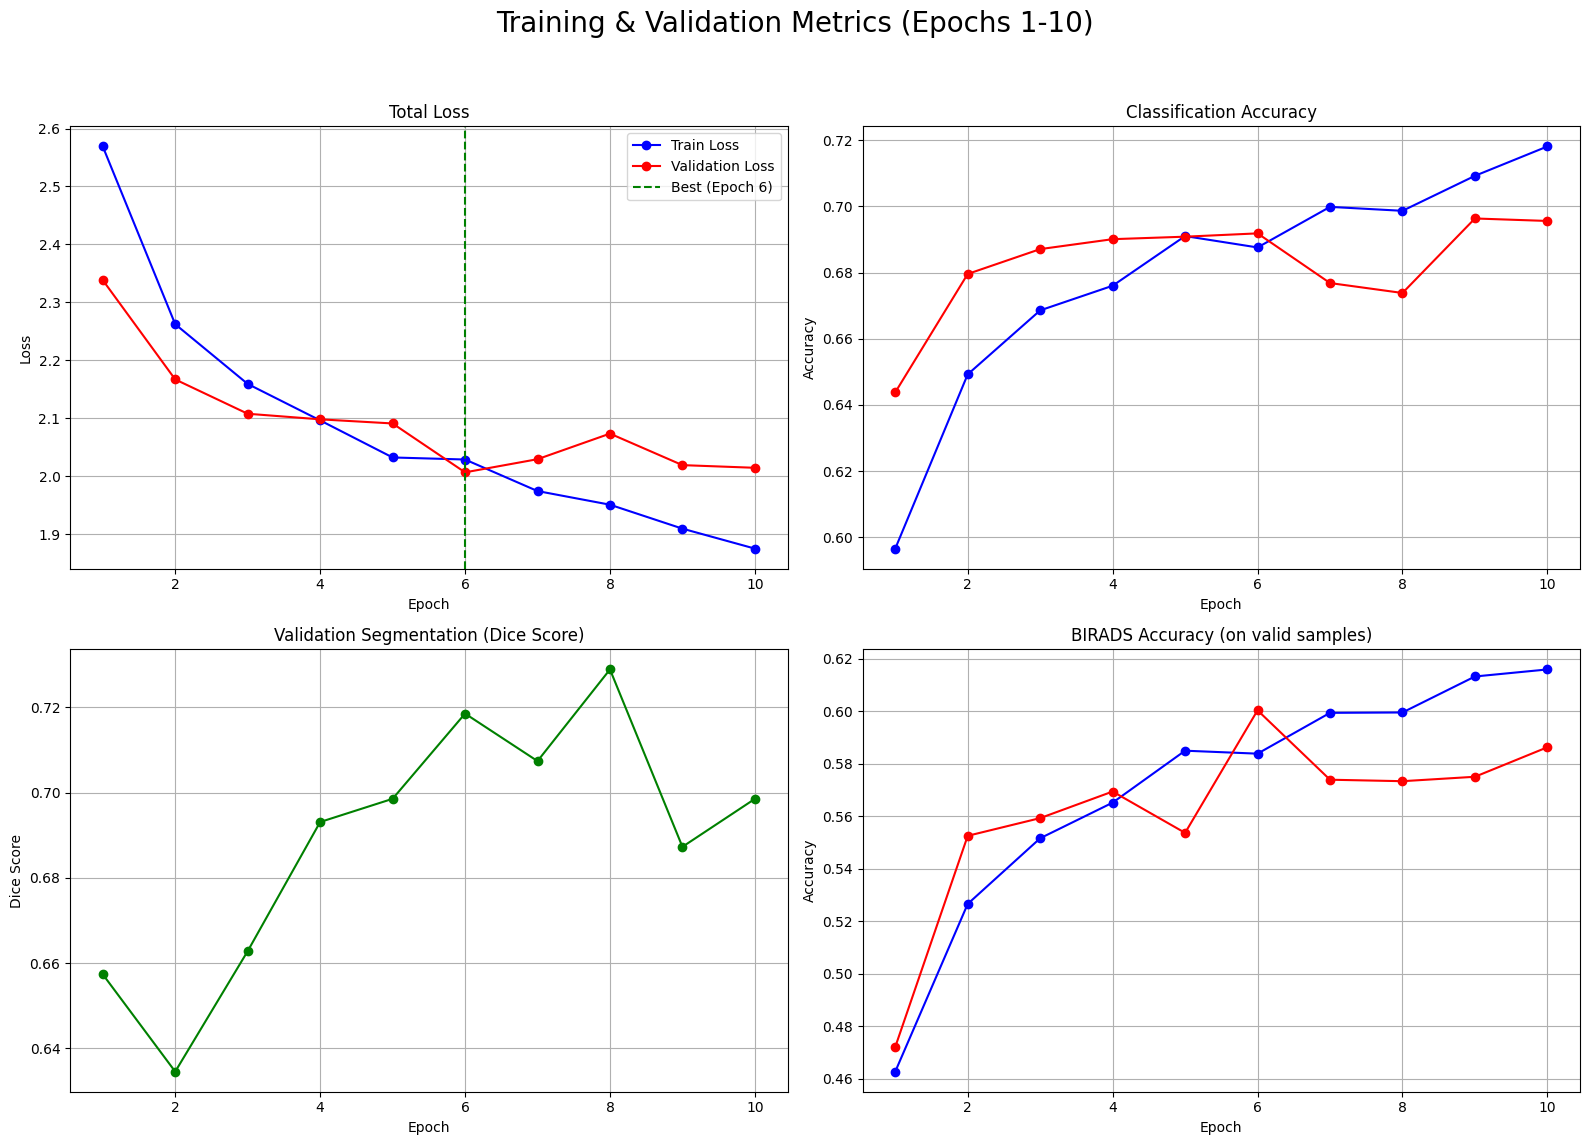

In [9]:
# Cell 10: Plotting Training Results

import pandas as pd
import matplotlib.pyplot as plt

print("--- Plotting Results from 'training_history.csv' ---")

# --- 1. Load the History ---
# This file was created and updated by our training loop (Cell 8)
try:
    history_df = pd.read_csv(HISTORY_FILE)
    print(f"Loaded history from {HISTORY_FILE}. Found {len(history_df)} epochs.")
except FileNotFoundError:
    print(f"--- ERROR ---")
    print(f"Could not find {HISTORY_FILE}. Did Cell 8 run and save it?")
    # If this happens, we can't plot, so we'll stop this cell.
    raise

# --- 2. Create Plots ---
# We'll create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training & Validation Metrics (Epochs 1-10)', fontsize=20)

epochs = history_df['epoch']

# --- Plot 1: Loss ---
axes[0, 0].plot(epochs, history_df['train_loss'], 'b-o', label='Train Loss')
axes[0, 0].plot(epochs, history_df['val_loss'], 'r-o', label='Validation Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)
# Add a line for the best loss
best_loss_epoch = history_df['val_loss'].idxmin() + 1
axes[0, 0].axvline(best_loss_epoch, color='g', linestyle='--', label=f'Best (Epoch {best_loss_epoch})')
axes[0, 0].legend()


# --- Plot 2: Classification Accuracy ---
axes[0, 1].plot(epochs, history_df['train_cls_acc'], 'b-o', label='Train Cls Acc')
axes[0, 1].plot(epochs, history_df['val_cls_acc'], 'r-o', label='Validation Cls Acc')
axes[0, 1].set_title('Classification Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].grid(True)

# --- Plot 3: Validation Dice Score ---
axes[1, 0].plot(epochs, history_df['val_dice'], 'g-o', label='Validation Dice')
axes[1, 0].set_title('Validation Segmentation (Dice Score)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Dice Score')
axes[1, 0].grid(True)

# --- Plot 4: BIRADS Accuracy ---
axes[1, 1].plot(epochs, history_df['train_birads_acc'], 'b-o', label='Train BIRADS Acc')
axes[1, 1].plot(epochs, history_df['val_birads_acc'], 'r-o', label='Validation BIRADS Acc')
axes[1, 1].set_title('BIRADS Accuracy (on valid samples)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].grid(True)

# --- 3. Save and Show ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Save the plot, per your request!
plt.savefig(PLOT_FILE)
print(f"Plots saved to {PLOT_FILE}")

# Show the plots
plt.show()

In [10]:
# Cell 11: The Grand Finale - Inference Pipeline (UPGRADED)

import pickle
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
import warnings

# Suppress warnings from the inference function
warnings.filterwarnings('ignore')

# --- 1. Define the Preprocessing for a SINGLE image ---
#    (This is just the 'val_transforms' from Cell 3, but for a single image)

def preprocess_single_image(image, img_size=IMG_SIZE):
    """
    Applies the validation transformations to a single PIL image.
    """
    # 1. Base transforms
    resize = transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.LANCZOS)
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])
    
    # 2. Apply them
    image = resize(image)
    image = to_tensor(image)
    image = normalize(image)
    
    # 3. Add batch dimension (B, C, H, W)
    image = image.unsqueeze(0) 
    
    return image

# --- 2. The Main Inference Function ---

def predict_unseen_image(image_path, model_path, label_encoder_path):
    """
    Takes a path to an unseen image and returns the classification,
    segmentation mask, and predicted BIRADS score.
    """
    
    print(f"--- Starting prediction for: {image_path} ---")
    
    # --- A. Load Components ---
    
    # 1. Load Label Encoder
    try:
        with open(label_encoder_path, 'rb') as f:
            le = pickle.load(f)
    except FileNotFoundError:
        print(f"ERROR: Could not find label encoder at {label_encoder_path}")
        return None, None, None
        
    # 2. Load Model Structure
    model = MultiTaskSwin(
        num_classes=len(le.classes_),
        num_birads_classes=7 # This must match the trained model
    )
    
    # 3. Load Trained Weights
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        print(f"ERROR: Could not find model file at {model_path}")
        print("Did Cell 8 run and save 'model_best.pth'?")
        return None, None, None
    
    model.to(device)
    model.eval() # *** VERY IMPORTANT: Set to evaluation mode ***
    
    # --- B. Process the Image ---
    
    # 1. Load the raw image (using our function from Cell 2)
    original_pil_image = load_image(image_path)
    if original_pil_image is None:
        print(f"ERROR: Could not load image from {image_path}")
        return None, None, None
    
    # 2. Apply transforms
    input_tensor = preprocess_single_image(original_pil_image.copy())
    input_tensor = input_tensor.to(device)
    
    # --- C. Get Predictions ---
    with torch.no_grad(): # No gradients needed for inference
        cls_logits, seg_logits, birads_logits = model(input_tensor)
    
    # --- D. Decode the Results ---
    
    # 1. Decode Classification
    pred_class_index = torch.argmax(cls_logits, dim=1).item() 
    pred_class_label = le.inverse_transform([pred_class_index])[0]
    
    # 2. Decode Segmentation
    seg_probs = torch.sigmoid(seg_logits)
    seg_mask = (seg_probs > 0.5).float()
    seg_mask_squeezed = seg_mask.squeeze().cpu().numpy()
    pred_mask_image = Image.fromarray((seg_mask_squeezed * 255).astype(np.uint8), mode='L')
    
    # 3. Decode BIRADS (NEW!)
    # This is a 7-class (0-6) classification
    pred_birads_score = torch.argmax(birads_logits, dim=1).item()
    
    print("--- Prediction Complete ---")
    
    # Return all 3 results, plus the original image for plotting
    return original_pil_image, pred_class_label, pred_mask_image, pred_birads_score

print("Inference function 'predict_unseen_image' is defined!")
print("Ready for the final test cell (Cell 12).")

Inference function 'predict_unseen_image' is defined!
Ready for the final test cell (Cell 12).


--- Model Test Drive ---
Using best model: ./checkpoints/model_epoch_4.pth
Using encoder: label_encoder.pkl
--- Starting prediction for: IMG012.tif ---
Backbone loaded. Seg features: 96, Cls/BIRADS features: 768
--- Prediction Complete ---


--- FINAL RESULTS ---
  ✅ Classification: Benign
  ✅ Predicted BIRADS: 1


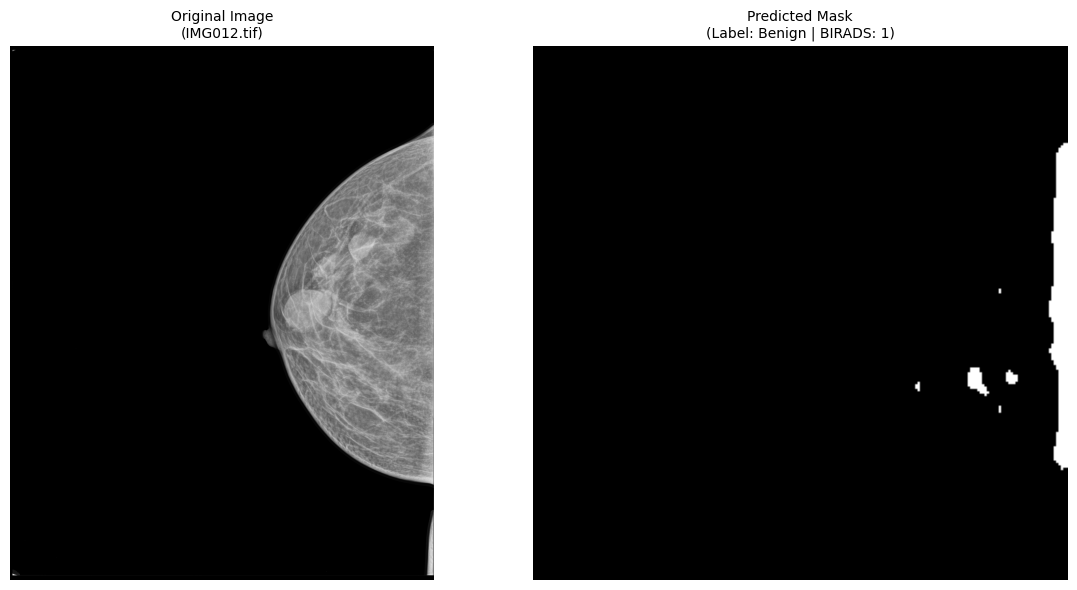

In [ ]:
# Cell 12: The "Test Drive" - Run Your Model!

import matplotlib.pyplot as plt

# --- 1. Define Paths to Your Assets ---
MODEL_TO_TEST_PATH = os.path.join(CHECKPOINT_DIR, 'model_best.pth')
ENCODER_PATH = 'label_encoder.pkl'

# --- 2. Get User Input ---
print("--- Model Test Drive ---")
print(f"Using best model: {MODEL_TO_TEST_PATH}")
print(f"Using encoder: {ENCODER_PATH}")

image_path_to_test = input("\n>>> Please paste the full relative path to your test image: ")

# --- 3. Run the Pipeline ---
try:
    # Run our master function from Cell 11
    original_image, label, mask, birads = predict_unseen_image(
        image_path=image_path_to_test,
        model_path=MODEL_TO_TEST_PATH,
        label_encoder_path=ENCODER_PATH
    )

    # --- 4. Show the Results ---
    if original_image:
        print("\n\n--- FINAL RESULTS ---")
        print(f"  ✅ Classification: {label}")
        print(f"  ✅ Predicted BIRADS: {birads}")
        
        # Plot the images side-by-side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        axes[0].imshow(original_image, cmap='gray')
        axes[0].set_title(f"Original Image\n({image_path_to_test})", fontsize=10)
        axes[0].axis('off')
        
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title(f"Predicted Mask\n(Label: {label} | BIRADS: {birads})", fontsize=10)
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"\n--- An Error Occurred ---")
    print(f"Could not process the image. Error: {e}")
    print("Please check that the path is correct and the file is a valid image.")